In [1]:
from data_processing import get_data
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Input, LSTM, Dense, concatenate
from keras import Model, optimizers, losses, metrics
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices('GPU'))

C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
normal_data, abnormal_data, real_abnormal_data, real_abnormal_data_2 = get_data("sherbrooke")

Normal data shape: (20606, 125)
Abnormal data shape: (186, 125)
Real abnormal data shape: (406, 125)
Real abnormal data 2 shape: (406, 125)


In [3]:
# Transform ndarrays to keras tensors
normal_data = tf.convert_to_tensor(normal_data)
abnormal_data = tf.convert_to_tensor(abnormal_data)
real_abnormal_data = tf.convert_to_tensor(real_abnormal_data)
real_abnormal_data_2 = tf.convert_to_tensor(real_abnormal_data_2)

In [4]:
data = tf.concat([normal_data, abnormal_data, real_abnormal_data, real_abnormal_data_2], 0)
data.shape

TensorShape([21604, 125])

In [5]:
# Create the labels, since we will be doing supervised learning. 1 represents a normal trajectory, 0 is abnormal
labels = np.concatenate([
    np.ones(normal_data.shape[0]),
    np.zeros(abnormal_data.shape[0]),
    np.zeros(real_abnormal_data.shape[0]),
    np.zeros(real_abnormal_data_2.shape[0])
], 0)

labels = np.reshape(labels, [-1, 1])
labels.shape

(21604, 1)

In [6]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 21604
    Normal: 20606 (95.38% of total)



In [7]:
data = tf.concat([data, labels], 1)
data.shape

TensorShape([21604, 126])

In [8]:
train_data, test_data = train_test_split(data.numpy(), test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [9]:
train_labels = train_data[:,-1].astype('int32')
train_categories = train_data[:,0].astype('int32')
train_data = train_data[:,1:-1]

val_labels = val_data[:,-1].astype('int32')
val_categories = val_data[:,0].astype('int32')
val_data = val_data[:,1:-1]

test_labels = test_data[:,-1].astype('int32')
test_categories = test_data[:,0].astype('int32')
test_data = test_data[:,1:-1]

In [10]:
print(train_labels.shape)
print(train_categories.shape)
print(train_data.shape)

(13826,)
(13826,)
(13826, 124)


In [11]:
# The category data needs to be one-hot encoded
train_categories = np.reshape(train_categories, newshape=[-1, 1])
val_categories = np.reshape(val_categories, newshape=[-1, 1])
test_categories = np.reshape(test_categories, newshape=[-1, 1])

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(train_categories)
one_hot_encoder.fit(val_categories)
one_hot_encoder.fit(test_categories)

train_categories = one_hot_encoder.transform(train_categories)
val_categories = one_hot_encoder.transform(val_categories)
test_categories = one_hot_encoder.transform(test_categories)

In [12]:
train_categories.shape

(13826, 2)

In [13]:
# The trajectory data however needs to be reshaped into data containing 31 timesteps for 4 features.
# The trajectory features are the x and y location, and the x and y velocities over 31 timesteps

features = 4
timesteps = int(train_data.shape[1] / features)

train_data = np.transpose(np.reshape(train_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
val_data = np.transpose(np.reshape(val_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
test_data = np.transpose(np.reshape(test_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])

train_data.shape

(13826, 4, 31)

In [14]:
train_labels.shape

(13826,)

In [15]:
bool_train_labels = train_labels != 0

pos_features = train_data[bool_train_labels]
neg_features = train_data[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

pos_categories = train_categories[bool_train_labels]
neg_categories = train_categories[~bool_train_labels]

In [16]:
ids = np.arange(len(neg_features))
choices = np.random.choice(ids, len(pos_features))

res_neg_features = neg_features[choices]
res_neg_labels = neg_labels[choices]
res_neg_categories = neg_categories[choices]

res_neg_features.shape

(13184, 4, 31)

In [17]:
resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
resampled_categories = np.concatenate([res_neg_categories, pos_categories], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_categories = resampled_categories[order]

print(resampled_features.shape)
print(resampled_labels.shape)
print(resampled_categories.shape)

(26368, 4, 31)
(26368,)
(26368, 2)


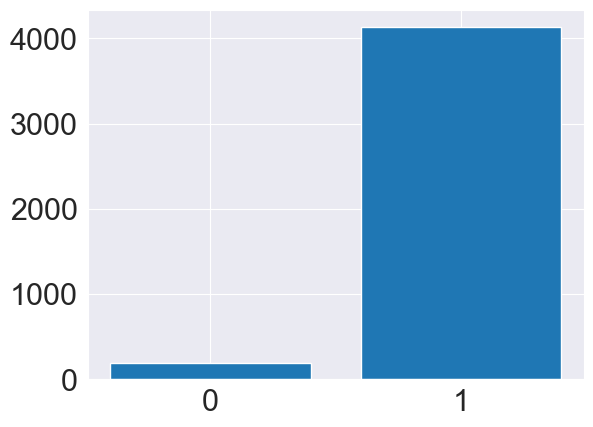

In [25]:
neg, pos = tf.math.bincount(test_labels)

plt.rcParams.update({'font.size': 22})
plt.xticks([0, 1])
plt.bar([0, 1], [neg, pos])
plt.show()

In [191]:
BATCH_SIZE=128

resampled_steps_per_epoch = np.ceil(2.0*pos.numpy()/BATCH_SIZE)
resampled_steps_per_epoch

186.0

In [192]:
# Now to define the network

# Trajectory data
trajectory_input_shape = resampled_features.shape[1:]
units = 100
trajectory_input = Input(shape=trajectory_input_shape)
trajectory_output = LSTM(units)(trajectory_input)

# Category data
category_input = Input(shape=resampled_categories.shape[1:])

# Merge and add dense layer
merge_layer = concatenate([category_input, trajectory_output])
main_output = Dense(units=1,activation="sigmoid")(merge_layer)

# Define the model with two inputs
model = Model(inputs=[trajectory_input, category_input], outputs=[main_output])

In [193]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy')
]

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [194]:
EPOCHS = 10

resampled_history = model.fit(
    [resampled_features, resampled_categories],
    resampled_labels,
    # These are not real epochs
    steps_per_epoch=resampled_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=([val_data, val_categories], val_labels))

Epoch 1/10
186/186 [==============================] - 6s 21ms/step - loss: 0.4965 - tp: 5575.0000 - fp: 1801.0000 - tn: 5918.0000 - fn: 2128.0000 - accuracy: 0.7452 - val_loss: 0.3075 - val_tp: 1583.0000 - val_fp: 15.0000 - val_tn: 114.0000 - val_fn: 313.0000 - val_accuracy: 0.8380
Epoch 2/10
186/186 [==============================] - 3s 16ms/step - loss: 0.2783 - tp: 6753.0000 - fp: 727.0000 - tn: 6951.0000 - fn: 991.0000 - accuracy: 0.8886 - val_loss: 0.1310 - val_tp: 1859.0000 - val_fp: 30.0000 - val_tn: 99.0000 - val_fn: 37.0000 - val_accuracy: 0.9669
Epoch 3/10
186/186 [==============================] - 3s 16ms/step - loss: 0.1627 - tp: 7306.0000 - fp: 500.0000 - tn: 7228.0000 - fn: 388.0000 - accuracy: 0.9424 - val_loss: 0.0653 - val_tp: 1893.0000 - val_fp: 12.0000 - val_tn: 117.0000 - val_fn: 3.0000 - val_accuracy: 0.9926
Epoch 4/10
186/186 [==============================] - 3s 15ms/step - loss: 0.0737 - tp: 7651.0000 - fp: 213.0000 - tn: 7514.0000 - fn: 44.0000 - accuracy: 0.98

In [240]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric):
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    # else:
    #   plt.ylim([0.7,1])

    plt.legend()

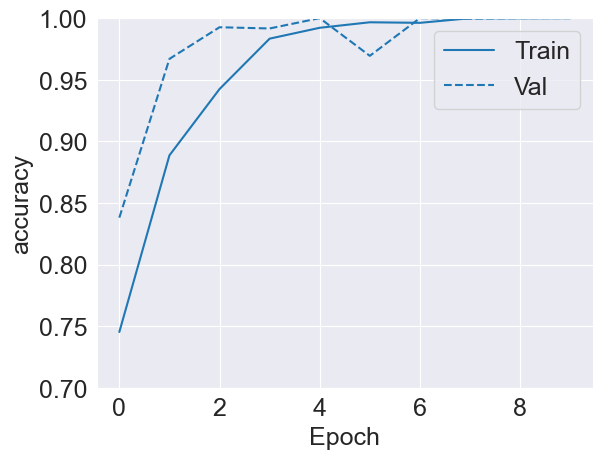

In [224]:
plot_metrics(resampled_history, "accuracy")

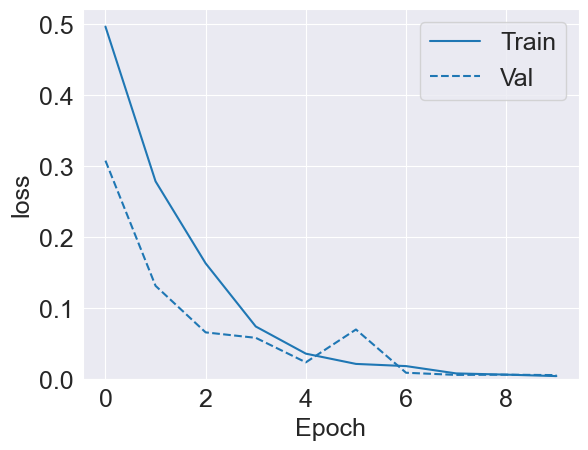

In [241]:
plot_metrics(resampled_history, "loss")

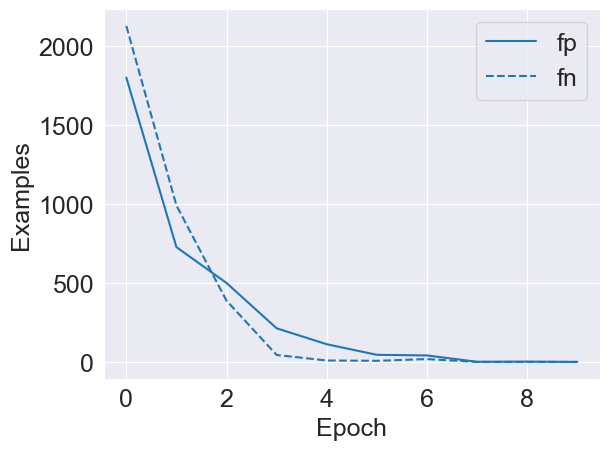

In [236]:
plt.plot(resampled_history.epoch, resampled_history.history['fp'], color=colors[0], label='fp')
plt.plot(resampled_history.epoch, resampled_history.history['fn'], color=colors[0], linestyle="--", label='fn')
plt.xlabel('Epoch')
plt.ylabel('Examples')

plt.legend()

In [197]:
resampled_results = model.evaluate([test_data, test_categories], test_labels, batch_size=BATCH_SIZE, verbose=0)

In [198]:
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

loss :  0.00542186526581645
tp :  2360.0
fp :  1.0
tn :  170.0
fn :  0.0
accuracy :  0.9996048808097839



In [199]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [200]:
test_predictions = model.predict([test_data, test_categories], batch_size=BATCH_SIZE)

20/20 [==============================] - 1s 4ms/step


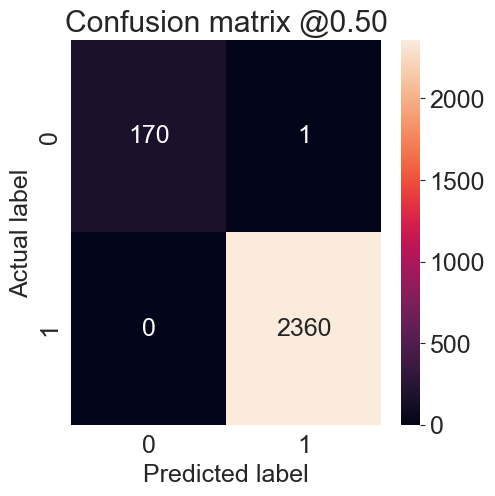

In [201]:
plot_cm(test_labels, test_predictions)